# Project: Homophily and Heterophily Analysis of Node Classification

**Package setup**

In [109]:
!pip install numpy matplotlib seaborn pandas
!pip3 install torch torchvision torchaudio
!pip install torch_geometric
!pip install torch-scatter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

**Find and Download Datasets for Node Classification**

In [110]:
import torch
from torch_geometric.datasets import Planetoid
import os

dataset_dir = os.path.join(os.getcwd(), 'data')

dataset_names = ['Cora', 'Citeseer', 'Pubmed']

datasets = {}
for dataset_name in dataset_names:
    dataset = Planetoid(root=dataset_dir, name=dataset_name)
    datasets[dataset_name] = dataset

    print(f"Dataset: {dataset_name}")
    print(f"Number of graphs: {len(dataset)}")
    print(f"Number of features: {dataset.num_features}")
    print(f"Number of classes: {dataset.num_classes}")

    data = dataset[0]
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.num_edges}")
    print(f"Node feature dimension: {data.x.shape[1]}")
    print(f"Edge indices: {data.edge_index}\n")

Dataset: Cora
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Node feature dimension: 1433
Edge indices: tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

Dataset: Citeseer
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Number of nodes: 3327
Number of edges: 9104
Node feature dimension: 3703
Edge indices: tensor([[ 628,  158,  486,  ..., 2820, 1643,   33],
        [   0,    1,    1,  ..., 3324, 3325, 3326]])

Dataset: Pubmed
Number of graphs: 1
Number of features: 500
Number of classes: 3
Number of nodes: 19717
Number of edges: 88648
Node feature dimension: 500
Edge indices: tensor([[ 1378,  1544,  6092,  ..., 12278,  4284, 16030],
        [    0,     0,     0,  ..., 19714, 19715, 19716]])



**Calculate Homophily and Heterophily of different networks**

In [123]:
import torch
import networkx as nx
from torch_geometric.datasets import Planetoid
import os

# Function to calculate Homophily and Heterophily
def calculate_homophily_heterophily(G, n_nodes_per_community, node_labels):
    intra_edges = 0
    inter_edges = 0
    for u, v in G.edges():
        # Check if nodes belong to the same community based on their labels
        if node_labels[u] == node_labels[v]:
            intra_edges += 1  # Intra-community edges
        else:
            inter_edges += 1  # Inter-community edges

    total_edges = intra_edges + inter_edges
    homophily = intra_edges / total_edges if total_edges > 0 else 0
    heterophily = inter_edges / total_edges if total_edges > 0 else 0

    return homophily, heterophily

In [124]:
# Load dataset
dataset_dir = os.path.join(os.getcwd(), 'data')
dataset_names = ['Cora', 'Citeseer', 'Pubmed']

datasets = {}
for dataset_name in dataset_names:
    dataset = Planetoid(root=dataset_dir, name=dataset_name)
    datasets[dataset_name] = dataset
    data = dataset[0]

    # Convert to NetworkX graph
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())

    # Calculate Homophily and Heterophily
    homophily, heterophily = calculate_homophily_heterophily(
        G,
        n_nodes_per_community=data.num_nodes // dataset.num_classes,
        node_labels=data.y.numpy()
    )

    # Print results in percentage
    print(f"Dataset: {dataset_name}")
    print(f"Homophily: {homophily * 100:.2f}%")
    print(f"Heterophily: {heterophily * 100:.2f}%")
    print()

Dataset: Cora
Homophily: 81.00%
Heterophily: 19.00%

Dataset: Citeseer
Homophily: 73.55%
Heterophily: 26.45%

Dataset: Pubmed
Homophily: 80.24%
Heterophily: 19.76%



**Code GNN-based models and obtain node classification performance**

Dataset: Cora, Epoch 0, Loss: 1.9504, Train Accuracy: 0.9071, Validation Accuracy: 0.5260, Test Accuracy: 0.5870
Dataset: Cora, Epoch 10, Loss: 0.0960, Train Accuracy: 1.0000, Validation Accuracy: 0.7620, Test Accuracy: 0.7910
Dataset: Cora, Epoch 20, Loss: 0.0066, Train Accuracy: 1.0000, Validation Accuracy: 0.7740, Test Accuracy: 0.7890
Dataset: Cora, Epoch 30, Loss: 0.0034, Train Accuracy: 1.0000, Validation Accuracy: 0.7700, Test Accuracy: 0.7840
Dataset: Cora, Epoch 40, Loss: 0.0056, Train Accuracy: 1.0000, Validation Accuracy: 0.7760, Test Accuracy: 0.7960
Dataset: Cora, Epoch 50, Loss: 0.0104, Train Accuracy: 1.0000, Validation Accuracy: 0.7780, Test Accuracy: 0.8130
Dataset: Cora, Epoch 60, Loss: 0.0127, Train Accuracy: 1.0000, Validation Accuracy: 0.7780, Test Accuracy: 0.8070
Dataset: Cora, Epoch 70, Loss: 0.0118, Train Accuracy: 1.0000, Validation Accuracy: 0.7740, Test Accuracy: 0.8050
Dataset: Cora, Epoch 80, Loss: 0.0107, Train Accuracy: 1.0000, Validation Accuracy: 0.772

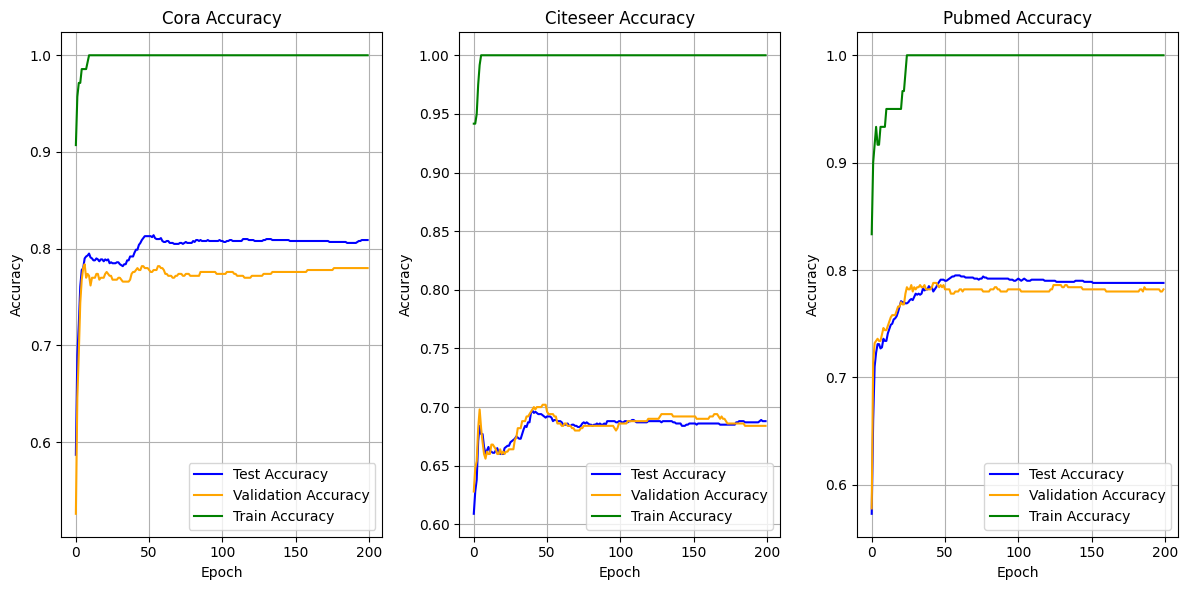

Final Validation Accuracy for Cora: 0.8090
Final Validation Accuracy for Citeseer: 0.6880
Final Validation Accuracy for Pubmed: 0.7880


In [137]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Set dataset directory
dataset_dir = os.path.join(os.getcwd(), 'data')

# Define the GCN model for node classification
class GCNNodeClassification(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNodeClassification, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Function to train the model
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)  # Get node embeddings
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])  # Use cross entropy for classification
    loss.backward()
    optimizer.step()
    return loss

# Function to test the model
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)  # Get node embeddings
    # Predict the classes based on the output
    _, pred = out.max(dim=1)

    # Compute accuracy for train, validation, and test sets
    train_acc = (pred[data.train_mask] == data.y[data.train_mask]).sum().float() / data.train_mask.sum().float()
    val_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum().float() / data.val_mask.sum().float()
    test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().float() / data.test_mask.sum().float()

    return train_acc, val_acc, test_acc

# Prepare data for each dataset (Cora, Citeseer, Pubmed)
dataset_names = ['Cora', 'Citeseer', 'Pubmed']
results = {}

# Create a figure for plotting loss and accuracy
plt.figure(figsize=(12, 6))

for dataset_name in dataset_names:
    dataset = Planetoid(root=dataset_dir, name=dataset_name)
    data = dataset[0]

    # Initialize the model and optimizer
    model = GCNNodeClassification(dataset.num_features, 64, dataset.num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    # Initialize lists to store loss and accuracy for plotting
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    # Training loop
    for epoch in range(200):
        loss = train(model, data, optimizer)  # Train the model
        train_losses.append(loss.item())  # Store the loss

        # Calculate train, val, and test accuracies
        train_acc, val_acc, test_acc = test(model, data)
        train_accuracies.append(train_acc.item())
        val_accuracies.append(val_acc.item())
        test_accuracies.append(test_acc.item())

        if epoch % 10 == 0:
            print(f"Dataset: {dataset_name}, Epoch {epoch}, Loss: {loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}")

    # Store the final test accuracy for the dataset
    results[dataset_name] = test_accuracies[-1]

    # Plot the loss and accuracy for the current dataset
    plt.subplot(1, len(dataset_names), dataset_names.index(dataset_name) + 1)
    plt.plot(range(200), test_accuracies, label="Test Accuracy", color="blue")
    plt.plot(range(200), val_accuracies, label="Validation Accuracy", color="orange")
    plt.plot(range(200), train_accuracies, label="Train Accuracy", color="green")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{dataset_name} Accuracy')
    plt.legend()
    plt.grid(True)

# Show the plot with training losses and accuracies
plt.tight_layout()
plt.show()

# Print the final results
for dataset_name, test_acc in results.items():
    print(f"Final Validation Accuracy for {dataset_name}: {test_acc:.4f}")


**Analyze the relationship between the homophily of a network/dataset and its corresponding node classification performance**


**Implemented more GNN models(GCN, GAT, GraphSAGE) on the three datasets**

In [133]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
import matplotlib.pyplot as plt
import networkx as nx
import os
import time  # Importing the time module

# Define models: GCN, GAT, GraphSAGE
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Function to calculate homophily
def calculate_homophily(G, node_labels):
    intra_edges = 0
    inter_edges = 0
    for u, v in G.edges():
        if node_labels[u] == node_labels[v]:
            intra_edges += 1
        else:
            inter_edges += 1
    total_edges = intra_edges + inter_edges
    return intra_edges / total_edges if total_edges > 0 else 0

# Train and test functions
def train(model, data, optimizer, train_mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accuracy = (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()
    return accuracy

# Load datasets and process for each model
dataset_dir = os.path.join(os.getcwd(), 'data')
dataset_names = ['Cora', 'Citeseer', 'Pubmed']
models = {'GCN': GCN, 'GAT': GAT, 'GraphSAGE': GraphSAGE}

results = {model_name: {'train_acc': [], 'val_acc': [], 'test_acc': [], 'homophily': [], 'execution_time': []} for model_name in models}

for dataset_name in dataset_names:
    dataset = Planetoid(root=dataset_dir, name=dataset_name)
    data = dataset[0]

    # Convert to NetworkX graph and calculate homophily
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())
    homophily = calculate_homophily(G, data.y.numpy())

    for model_name, ModelClass in models.items():
        model = ModelClass(dataset.num_features, 64, dataset.num_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

        # Start timing the model execution
        start_time = time.time()

        # Train and record accuracies
        for epoch in range(200):
            train_loss = train(model, data, optimizer, data.train_mask)

        train_acc = test(model, data, data.train_mask)
        val_acc = test(model, data, data.val_mask)
        test_acc = test(model, data, data.test_mask)

        # End timing the model execution
        end_time = time.time()

        # Save results
        results[model_name]['train_acc'].append(train_acc)
        results[model_name]['val_acc'].append(val_acc)
        results[model_name]['test_acc'].append(test_acc)
        results[model_name]['homophily'].append(homophily)
        results[model_name]['execution_time'].append(end_time - start_time)

        print(f"{model_name} on {dataset_name}: Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}, Time: {end_time - start_time:.2f} seconds")

GCN on Cora: Train: 1.0000, Val: 0.7780, Test: 0.8060, Time: 6.61 seconds
GAT on Cora: Train: 1.0000, Val: 0.7160, Test: 0.7640, Time: 8.94 seconds
GraphSAGE on Cora: Train: 1.0000, Val: 0.7780, Test: 0.7970, Time: 16.70 seconds
GCN on Citeseer: Train: 1.0000, Val: 0.6820, Test: 0.6860, Time: 19.04 seconds
GAT on Citeseer: Train: 1.0000, Val: 0.6800, Test: 0.6780, Time: 19.45 seconds
GraphSAGE on Citeseer: Train: 1.0000, Val: 0.6940, Test: 0.7030, Time: 62.90 seconds
GCN on Pubmed: Train: 1.0000, Val: 0.7780, Test: 0.7880, Time: 26.28 seconds
GAT on Pubmed: Train: 1.0000, Val: 0.7300, Test: 0.6880, Time: 36.45 seconds
GraphSAGE on Pubmed: Train: 1.0000, Val: 0.7900, Test: 0.7590, Time: 70.80 seconds


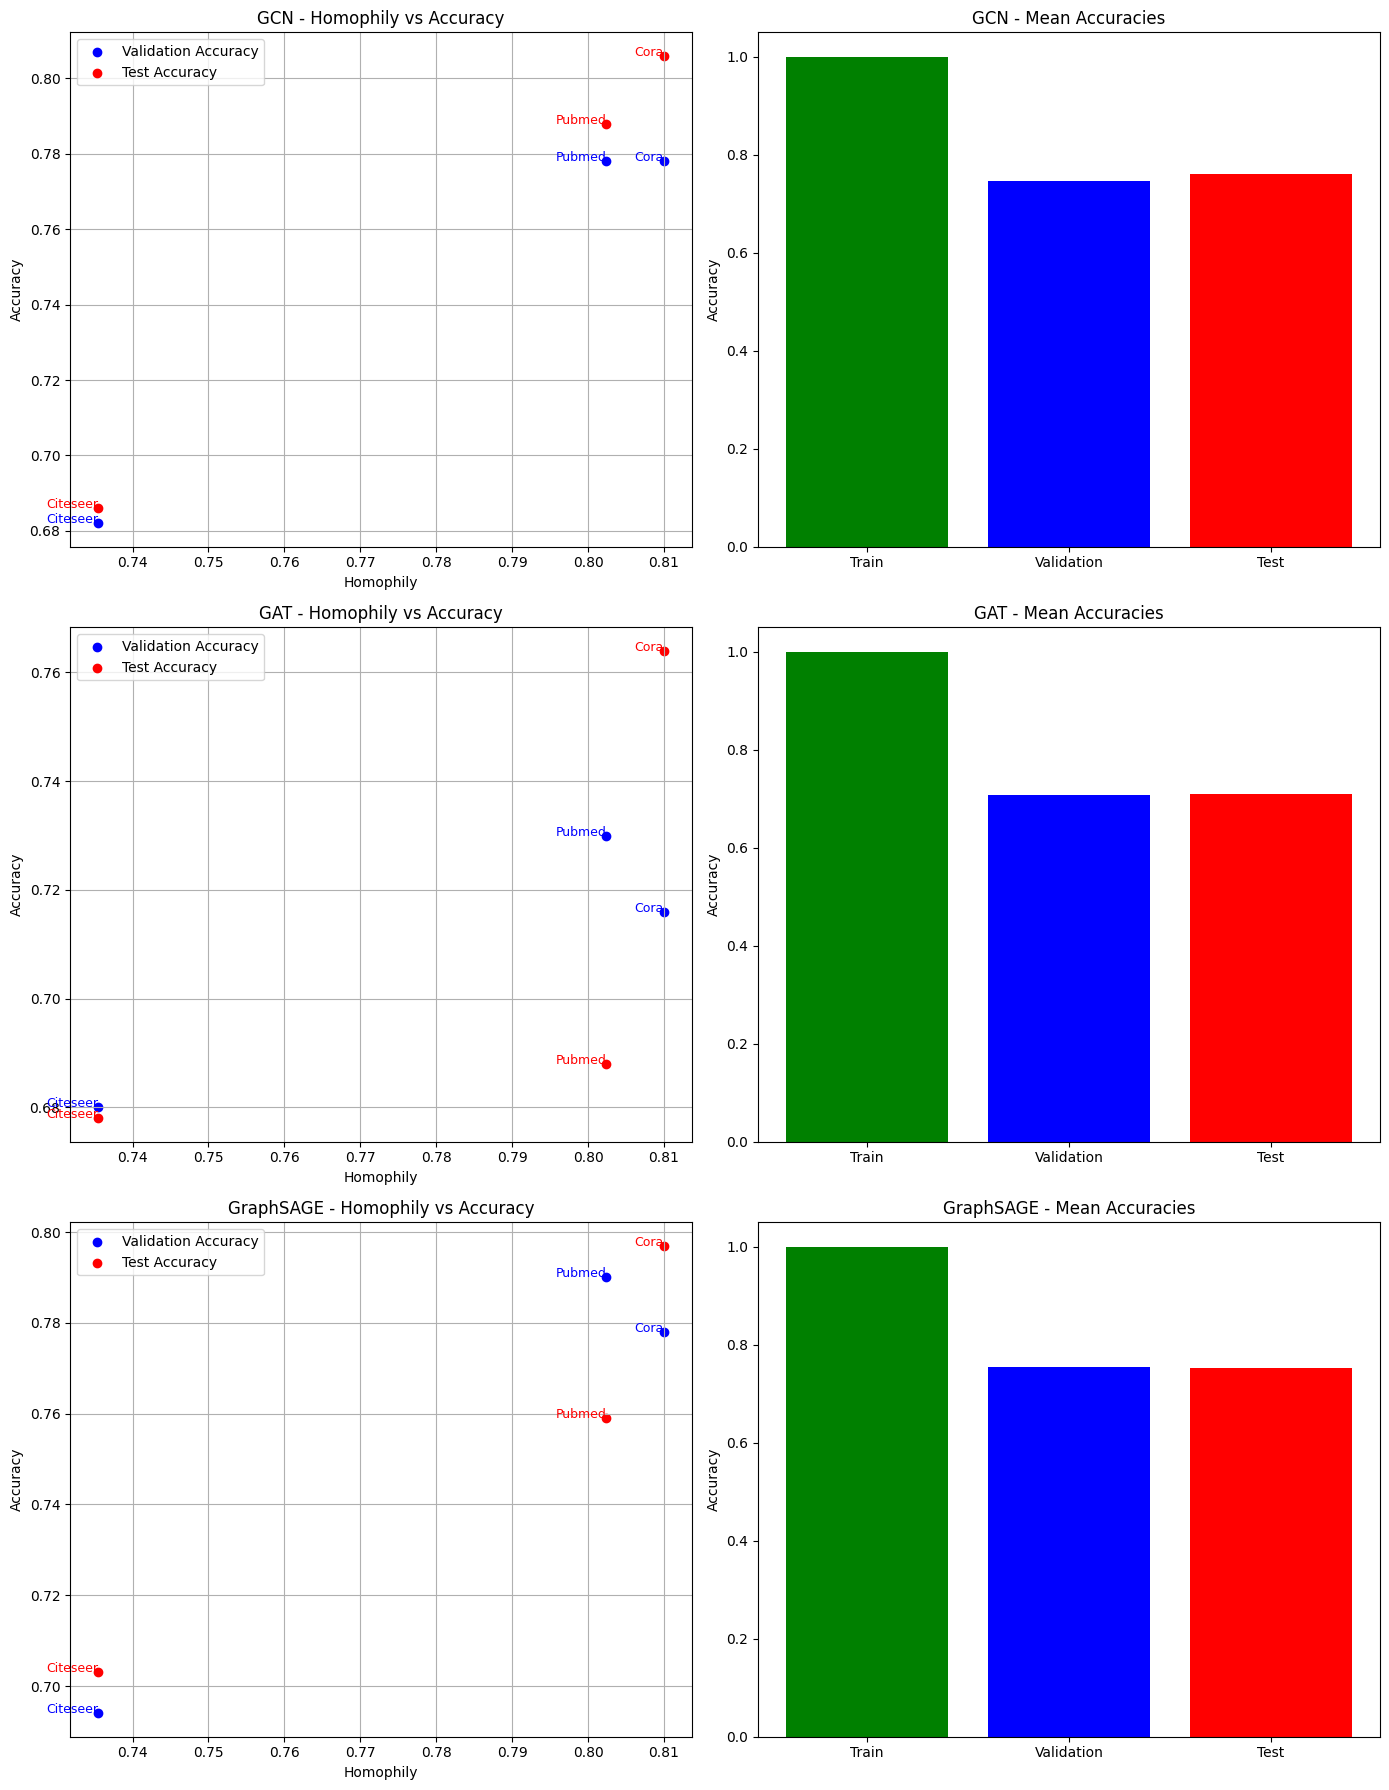

In [135]:
# Plot results
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.flatten()

dataset_names = ['Cora', 'Citeseer', 'Pubmed']

for idx, model_name in enumerate(models.keys()):
    homophily = results[model_name]['homophily']
    train_acc = results[model_name]['train_acc']
    val_acc = results[model_name]['val_acc']
    test_acc = results[model_name]['test_acc']
    exec_time = results[model_name]['execution_time']

    scatter_val = axes[idx * 2].scatter(homophily, val_acc, label='Validation Accuracy', color='blue')
    scatter_test = axes[idx * 2].scatter(homophily, test_acc, label='Test Accuracy', color='red')

    for i, dataset_name in enumerate(dataset_names):
        axes[idx * 2].text(homophily[i], val_acc[i], dataset_name, fontsize=9, color='blue', ha='right')
        axes[idx * 2].text(homophily[i], test_acc[i], dataset_name, fontsize=9, color='red', ha='right')

    axes[idx * 2].set_title(f"{model_name} - Homophily vs Accuracy")
    axes[idx * 2].set_xlabel('Homophily')
    axes[idx * 2].set_ylabel('Accuracy')
    axes[idx * 2].legend()
    axes[idx * 2].grid(True)

    axes[idx * 2 + 1].bar(['Train', 'Validation', 'Test'], [np.mean(train_acc), np.mean(val_acc), np.mean(test_acc)], color=['green', 'blue', 'red'])
    axes[idx * 2 + 1].set_title(f"{model_name} - Mean Accuracies")
    axes[idx * 2 + 1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

I used AI assistance to finish the project and adjust the alignment of my report.